設定檔

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys

變數設定

In [3]:
#setup some constants and parameters
M=2**16 #模擬步數
tsim=7e-12 #模擬長度
eps0 = 8.854187e-12 
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12 # hbar/kb
T=3000
deltap = np.sqrt(1/3/eps0/hbar/c)*kb*T #小delta 

D

In [4]:
def D(omega,T):
    return(hbar*omega/np.pi/c/(np.exp(hdk*omega/T)-1))

畫出D

/tmp/ipykernel_6232/2430332773.py:2: RuntimeWarning: invalid value encountered in divide
  return(hbar*omega/np.pi/c/(np.exp(hdk*omega/T)-1))


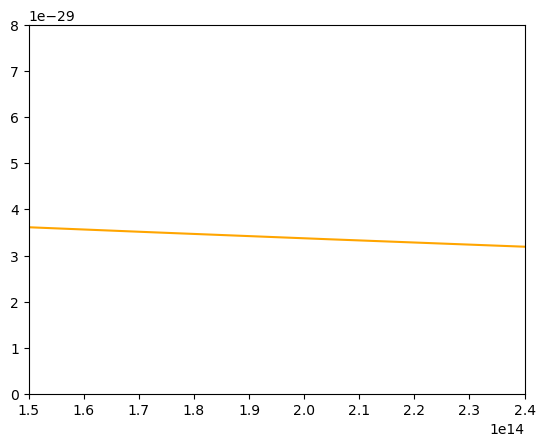

In [8]:
limit=1000
frequency_limit = np.linspace(0, 25, limit)
frequency = frequency_limit*10**14
omega = frequency*np.pi*2
plt.xlim(1.5e14,2.4e14)
plt.ylim(0,8e-29)
plt.plot(omega,D(omega,3000),'orange')
#plt.plot(omega,D(omega,5000),'red')
plt.savefig('3000K_1.5_4.5e14.png')
#plt.xlabel('Frequency (PHz)')
#plt.ylabel('Energy density (J/m)')

Dn

In [71]:
#define square root of Dn function
def Dn(wla,T):
    return 6*(hdk**2)*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi

畫Dn

設定Dnsqrt數列

In [81]:
#generate an array of the square root of Dn function
def Dnsqrt(wla,T):
    return np.sqrt(6*(hdk**2)*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)
Dsqr = []
for n in range(1,M):
    Dsqr.append(Dnsqrt(abs(2*np.pi*n/tsim),T))


重複計算頻均次數

In [75]:
#define how many times to run to average the results
Ncomp=10
#define the starting sum of the result
Efsum = np.zeros(2*M)

FFT 過程 包含數列擺正

In [77]:
for i in range(Ncomp):
    
    #generate random numbers
    M0 = np.random.normal(0,1)
    Mlp = np.random.normal(0,1,M-1)
    Nlp = np.random.normal(0,1,M-1)
    MM = np.random.normal(0,1)
    
    #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
    #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
    #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
    Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
    Eflp = np.multiply((Mlp + 1j*Nlp), Dsqr)
    Eflm = np.flip(np.conjugate(Eflp))
    EfM = np.array([MM*Dnsqrt(2*np.pi*M/tsim,T)])
    Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
    #we normalize Ef and compute its inverse fast fourier transform
    Efn = deltap/np.sqrt(tsim)*Ef
    En = np.fft.ifft(Efn)
    
    #we compute self correlation of En
    Eautoc = signal.correlate(En,En)
    Eautocf = np.fft.fft(Eautoc[len(En)-1:])
    
    #extract the real value and add the value of this loop to the total sum
    Eautocf = np.real(Eautocf)
    Efsum += Eautocf
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('😁'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)

#average the final result
Efavg = Efsum/Ncomp



[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 90%

紀錄 數據

In [16]:
#save data to some file or reload file to write more data on it
#np.savez("Efavg_v3.npz", Efavg_30000 = Efavg)
#data = np.load("Efavg_v3.npz")
#data = dict(data)
#data["Efavg_30000"] = Efavg
#np.savez("Efavg_v3.npz",**data)


Text(0, 0.5, 'Magnitude')

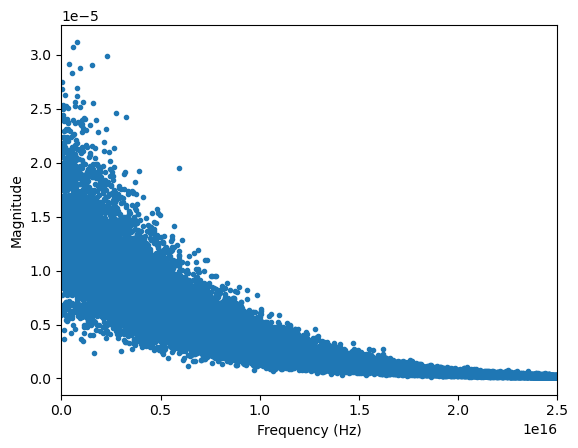

In [78]:
freqs = np.linspace(0,2*M*2*np.pi/(7*1e-12),4194304)
plt.plot(freqs,Efavg,'.')
plt.xlim(0,25*1e15)
#plt.ylim(0,8*1e-28)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

In [ ]:
timess = np.linspace(0,7*1e-12,4194304)
plt.plot(timess,En)
plt.xlim(0,2*1e-15)
plt.ylim(-3e-7,3e-7)
plt.xlabel('times')
plt.ylabel('Electric field source Es')

In [ ]:
timesss = np.linspace(-7*1e-12,7*1e-12,M*4-1)
plt.plot(timesss,Eautoc)
plt.xlim(-1e-15,1e-15)
plt.ylim(0,1e-7)
plt.xlabel('times')
plt.ylabel('Correlation function')